# Dogs vs. Cats
The training and testing data of this project is from a kaggle competetion https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview.\
The goal of this project is to correctly recognise pictures of dogs and cats.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


The directory tree of original data is
<pre>.
└── data
     ├── test
     │    ├── cat.jpg
     │    └── dog.jpg (12,500 files in total)       
     │           
     └── train
          ├── cat.jpg
          └── dog.jpg (25,000 files in total)
</pre>

For easily running the calculation, the following cell is to convert the directory tree into as
<pre>.
└── data
     ├── test
     │    ├── cat.jpg
     │    └── dog.jpg (12,500 files in total)       
     │           
     └── original_train
          ├── train
          │    ├── cat.jpg
          │    └── dog.jpg (20,000 files in total)
          └── validation
               ├── cat.jpg
               └── dog.jpg (5,000 files in total)
</pre>

If the original directory tree already works well, then mute the next cell.

In [2]:
# import shutil
# rootdir= './data/original_train' #path of the original folder

# os.makedirs(rootdir +'/train/')
# os.makedirs(rootdir +'/validation/')
# source = rootdir

# allFileNames = os.listdir(source)
# print(allFileNames[:10])
# np.random.shuffle(allFileNames)

# val_ratio = 0.2

# train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - val_ratio))])

# train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
# val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]

# for name in train_FileNames:
#     try:
#         shutil.copy(name, rootdir +'/train')
#     except:
#         print(name)

# for name in val_FileNames:
#     try:
#         shutil.copy(name, rootdir +'/validation')
#     except:
#         print(name)

# Data augmentation
Here is doing a variety of transformation for data augmentation such rotate, flip, etc, and normalisation.

In [3]:
# Examne the data
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

(416, 426)


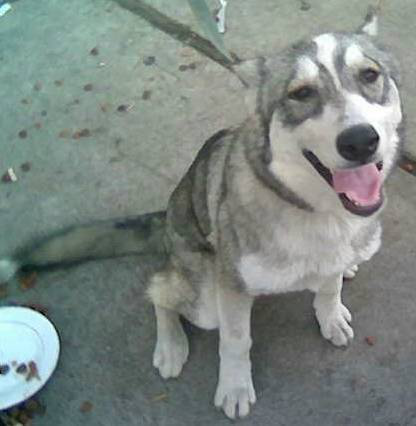

In [4]:
dog = Image.open('./Data/original_train/train/dog.7603.jpg')
print(dog.size)
display(dog)

In [5]:
r, g, b = dog.getpixel((0, 0))
print(r,g,b)

103 144 162


torch.Size([3, 426, 416])


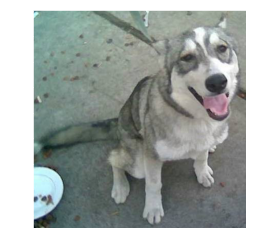

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Pytorch automatically loads the [0. 255] of range of RGB to [0, 1], so the RGB in the following process is normalised.

In [7]:
im[:,0,0]

tensor([0.4039, 0.5647, 0.6353])

### Transforms
All pictures are not in the same format, so we need to transform them into an apropriate format for further training our model.

torch.Size([3, 229, 224])


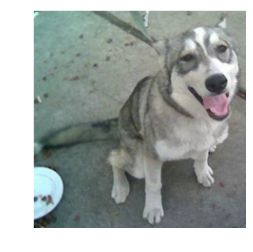

In [8]:
# resize 
transform = transforms.Compose([
    transforms.Resize(224),  # resize shortest side to 224 pixel, this command also works for making small picture bigger
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


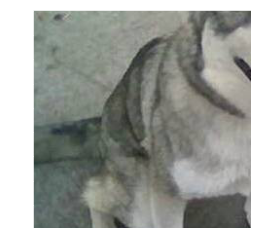

In [9]:
# centercrop
#If size is an integer instead of sequence like (h, w), a square crop of (size, size) is made.

transform = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog) # this crops the original image
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


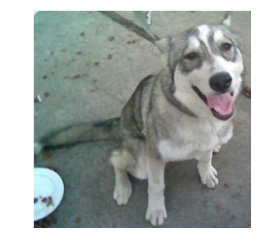

In [10]:
# combine the above two steps
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 426, 416])


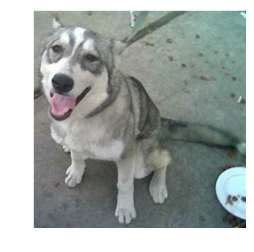

In [11]:
# horizontal flip
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # default p=0.5
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 426, 416])


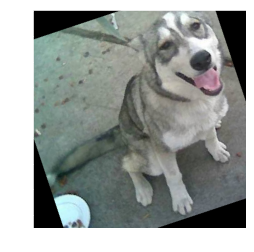

In [12]:
# rotate

transform = transforms.Compose([
    transforms.RandomRotation(30),  # rotate randomly between +/- 30 degrees
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

torch.Size([3, 224, 224])


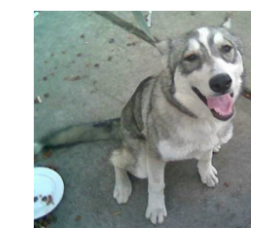

In [13]:
# scaling for different axis can be done by resize

transform = transforms.Compose([
    transforms.Resize((224,224)),  # be sure to pass in a list or a tuple
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Normalisation
Once the image is converted into tensor, we are able to perform normalisation on it. This serve to make convergence happen faster during training. The values are somewhat arbitrary - you can use a mean of 0.5 and a standard deviation of 0.5 to convert a range of [0,1] to [-1,1], for example.<br>However, <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>research has shown</a> that mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] work well in practice.

The transformation will be done for each channel of the input tensor as\
$\quad\textrm {input[channel]} = \frac{\textrm{input[channel] - mean[channel]}}{\textrm {std[channel]}}$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 426, 416])


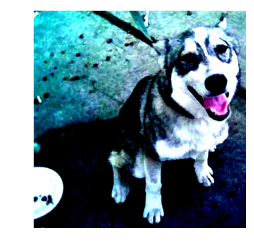

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [15]:
# After normalization:
im[:,0,0]

tensor([-0.3541,  0.4853,  1.0191])

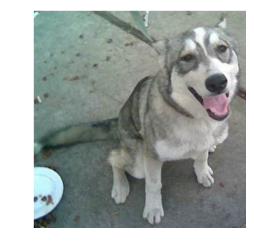

In [16]:
# de-normalisation for seeing the image back

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


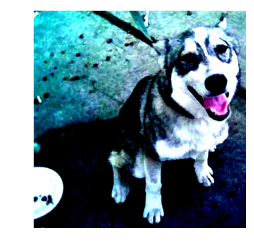

In [17]:
# Note that the original tensor was not modified back

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Define transformation for our calculation now

In [18]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

### Start by creating a list

In [19]:
from torch.utils.data import Dataset

### Prepare training set, testing sets, and loaders

In [20]:
class FoodDataset(Dataset):
    
    def __init__(self,path,tfm=test_transform,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label1 = fname.split("/")[-1].split(".")[0]
            if label1 == 'dog':
                label = 1
            elif label1 == 'cat':
                label = 0
        except:
            label = -1 # test has no label
        return im, label

In [21]:
batch_size = 10
_dataset_dir = "./data/original_train"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"train"), tfm=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One ./data/original_train/train sample ./data/original_train/train/cat.1.jpg
One ./data/original_train/validation sample ./data/original_train/validation/cat.0.jpg


Label: [1 0 0 1 0 1 0 0 1 1]


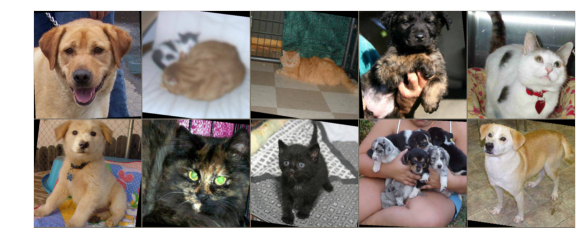

In [22]:
# Grab the first batch of 10 images
for images, labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
# print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Define model
We can define model by ourselve, or download a pre-trained model.

### Define by ourselve

In [23]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54 * 54 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54 * 54 * 16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

### Pre_trained model
Here I take AlexNetmodel through torchvision.models.

In [24]:
# pre_trained model
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
# We want to freeze the pre-trained weights & biases.
# We set param.requires_grad = False so we don't backprop through them.
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [26]:
# Modify the classifier to fit our case
# Note when we assign nre layers, their parameters default to param.requires_grad = True
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

### Setup other parameters

In [27]:
# This is for the progress bar if.
from tqdm.auto import tqdm
import random

_exp_name = "cat_dog"

In [28]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training patience.
patience = 50 # If no improvement in 'patience' epochs, early stop

model = CNNClassifier().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #, weight_decay=1e-5) 

model

CNNClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Train model

In [58]:
# train the alex model
import time
start_time = time.time()

epochs = 10
best_acc = 0
stale = 0

# control the number of imported data
max_trn_batch = 800 
max_val_batch = 300

train_losses = []
valid_losses = []
train_correct = []
valid_correct = []

for i in range(epochs):
    trn_corr = 0
    val_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i + 1:2}  training batch: {b:4} [{batch_size * b:6}/{batch_size * max_trn_batch:6}]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item() / (batch_size * b) * 100:7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(valid_loader):
            if b == max_val_batch:
                break
            
            b += 1
            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            val_corr += (predicted == y_test).sum()
            
            if b%100 == 0:
                print(f'epoch: {i + 1:2}  validation batch: {b:4} [{batch_size * b:6}/{batch_size * max_val_batch:6}]  loss: {loss.item():10.8f}  accuracy: {val_corr.item() / (batch_size * b) * 100:7.3f}%')

    loss = criterion(y_val, y_test)
    valid_losses.append(loss)
    valid_correct.append(val_corr)
    
    # extract the accuracy for the present epoch
    val_acc = val_corr.item() / (batch_size * b)
    
    # save models
    if val_acc > best_acc:
        best_acc = val_acc
        print(f"Best model found at epoch {i + 1}, saving model with val accuracy of {best_acc* 100:7.3f}%")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
    print('-' * 100)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  1  training batch:  200 [  2000/  4000]  loss: 0.72709149  accuracy:  78.400%
epoch:  1  training batch:  400 [  4000/  4000]  loss: 0.54313058  accuracy:  78.500%
epoch:  1  validation batch:  100 [  1000/  1000]  loss: 0.54313058  accuracy:  82.400%
Best model found at epoch 1, saving model with val accuracy of  82.400%
epoch:  2  training batch:  200 [  2000/  4000]  loss: 0.22280410  accuracy:  78.100%
epoch:  2  training batch:  400 [  4000/  4000]  loss: 0.43622142  accuracy:  79.050%
epoch:  2  validation batch:  100 [  1000/  1000]  loss: 0.43622142  accuracy:  70.300%
epoch:  3  training batch:  200 [  2000/  4000]  loss: 0.34036881  accuracy:  77.650%
epoch:  3  training batch:  400 [  4000/  4000]  loss: 0.55377305  accuracy:  78.250%
epoch:  3  validation batch:  100 [  1000/  1000]  loss: 0.55377305  accuracy:  71.300%
epoch:  4  training batch:  200 [  2000/  4000]  loss: 0.36771378  accuracy:  79.700%
epoch:  4  training batch:  400 [  4000/  4000]  loss: 0.48963

KeyboardInterrupt: 

# Evaluate model performance

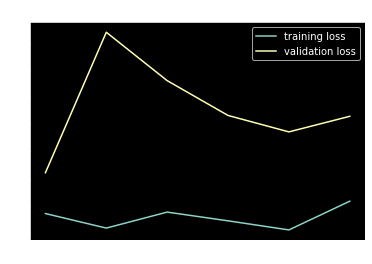

In [59]:
plt.plot(train_losses, label='training loss')
plt.plot(valid_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

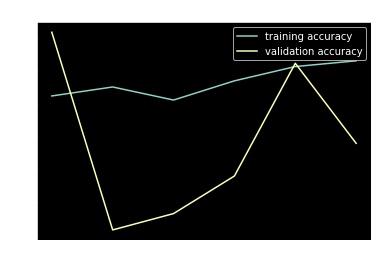

In [65]:
plt.plot([t/(max_trn_batch * batch_size) for t in train_correct], label='training accuracy')
plt.plot([t/(max_val_batch * batch_size) for t in valid_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [68]:
print(valid_correct)
print(f'Test accuracy: {valid_correct[-1].item() / max_val_batch * 10:.3f}%')

[tensor(824), tensor(703), tensor(713), tensor(736), tensor(805), tensor(756)]
Test accuracy: 75.600%
